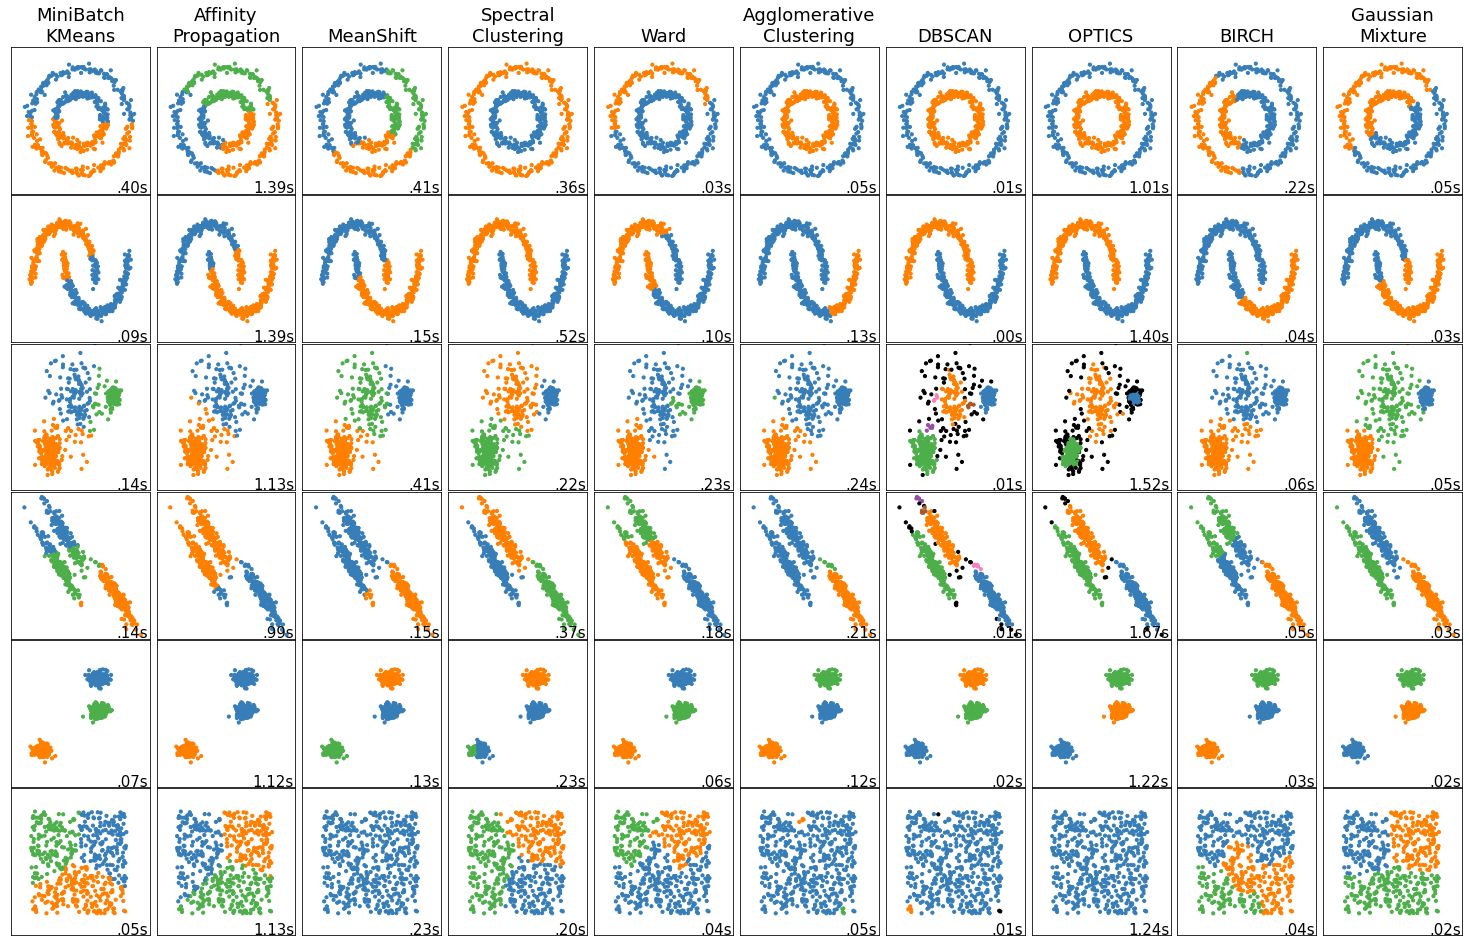

In [1]:
#1번
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
}

datasets = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.08,
        },
    ),
    (
        noisy_moons,
        {
            "damping": 0.75,
            "preference": -220,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.1,
        },
    ),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.01,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {"min_samples": 7, "xi": 0.1, "min_cluster_size": 0.2}),
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params["n_clusters"])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"], preference=params["preference"], random_state=0
    )
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        affinity="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )
    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"], covariance_type="full"
    )

    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("Affinity\nPropagation", affinity_propagation),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("Agglomerative\nClustering", average_linkage),
        ("DBSCAN", dbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        ("Gaussian\nMixture", gmm),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

In [285]:
#2번
# Mnist data set 불러오기

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import numpy as np

mnist = tf.keras.datasets.mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))
nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
(60000, 784) (60000,) (10000, 784) (10000,)


In [237]:
random.seed(100)
X_list = [[],[],[],[],[],[],[],[],[],[]]

for i in range(len(X_train)):
    if y_train[i] == 0:
        X_list[0].append(X_train[i])
    elif y_train[i] == 1:
        X_list[1].append(X_train[i])
    elif y_train[i] == 2:
        X_list[2].append(X_train[i])
    elif y_train[i] == 3:
        X_list[3].append(X_train[i])
    elif y_train[i] == 4:
        X_list[4].append(X_train[i])
    elif y_train[i] == 5:
        X_list[5].append(X_train[i])
    elif y_train[i] == 6:
        X_list[6].append(X_train[i])
    elif y_train[i] == 7:
        X_list[7].append(X_train[i])
    elif y_train[i] == 8:
        X_list[8].append(X_train[i])
    elif y_train[i] == 9:
        X_list[9].append(X_train[i])
        
#X
for i in range(10):
    X_list[i] = random.sample(X_list[i], 100)
print(len(X_list[4]))

new_X_train = np.concatenate(X_list, axis=0)
print(new_X_train.shape)

#y
y_list = []
for i in range(10):
    y_list.append([i]*100)

new_y_train = np.concatenate(y_list, axis=0)
print(len(new_y_train))
print(new_y_train.shape)

100
(1000, 784)
1000
(1000,)


In [149]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=10).fit_predict(new_X_train)

In [296]:
from sklearn.cluster import KMeans

Kmeans = KMeans(n_clusters=10).fit_predict(new_X_train)

In [169]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=10, random_state=0).fit_predict(new_X_train)

In [151]:
from sklearn.cluster import SpectralClustering

sc = SpectralClustering(n_clusters=10).fit_predict(new_X_train)

In [153]:
#4번
from sklearn.metrics.cluster import rand_score

print("Agglomerative clustering rand_score:", rand_score(new_y_train, agg))
print("k-means clustering rand_score:", rand_score(new_y_train, Kmeans))
print("Gaussian mixture model rand_score:", rand_score(new_y_train, gmm))
print("Spectral clustering rand_score:", rand_score(new_y_train, sc))

Agglomerative clustering rand_score: 0.9058998998998999
k-means clustering rand_score: 0.8916036036036036
Gaussian mixture model rand_score: 0.8788068068068068
Spectral clustering rand_score: 0.14221821821821823


In [154]:
from sklearn.metrics.cluster import mutual_info_score

print("Agglomerative clustering mutual_info_score:", mutual_info_score(new_y_train, agg))
print("k-means clustering mutual_info_score:", mutual_info_score(new_y_train, Kmeans))
print("Gaussian mixture model mutual_info_score:", mutual_info_score(new_y_train, gmm))
print("Spectral clustering mutual_info_score:", mutual_info_score(new_y_train, sc))

Agglomerative clustering mutual_info_score: 1.4080261759251629
k-means clustering mutual_info_score: 1.2486572156857298
Gaussian mixture model mutual_info_score: 1.1062010639164406
Spectral clustering mutual_info_score: 0.05234772010151926


In [ ]:
#############5번

In [310]:
Kmeans = KMeans(n_clusters=10).fit(new_X_train)
kmeans_centers = Kmeans.cluster_centers_

In [217]:
from collections import Counter

y_means = []

for i in range(10):
    cnt = Counter(y_list[i])
    y_means.append(cnt.most_common(1)[0][0])
    
print(y_means)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [311]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=10).fit_predict(new_X_train)

In [313]:
print(agg)

[1 1 1 1 1 1 1 1 1 1 2 1 1 5 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2
 1 5 1 5 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 1 1 1 2 1 1 1 1 1 1
 1 1 1 1 1 7 1 1 1 1 1 1 3 5 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 7 2 7 7 7 7 7 7 7 7 8 7 7 4 7 7 7 7 7 7 0
 7 7 7 7 7 7 7 7 4 7 9 7 7 7 7 7 7 7 7 7 7 7 4 7 8 7 7 7 7 7 7 7 7 7 7 7 7
 7 4 7 7 7 7 7 7 7 4 2 7 4 7 7 7 7 7 7 7 7 7 7 4 7 7 7 7 7 7 7 7 7 7 7 4 7
 7 7 7 7 3 4 4 4 3 3 3 4 4 4 4 4 3 4 4 4 3 4 4 3 3 4 4 4 3 4 4 4 4 3 3 4 4
 3 4 4 4 8 3 8 4 4 4 3 4 3 4 3 7 3 4 3 4 4 4 3 4 4 4 3 7 4 3 5 3 3 3 4 4 4
 4 4 3 4 4 4 4 9 2 3 4 4 4 3 2 3 3 4 4 4 4 4 3 4 3 3 4 6 8 4 6 6 6 6 8 8 8
 6 9 6 8 6 8 6 8 8 0 8 6 8 6 6 6 6 6 6 8 6 8 6 8 6 6 8 6 9 6 6 8 6 8 6 8 6
 6 6 8 8 3 6 6 8 8 8 6 8 6 7 6 6 8 8 9 6 9 8 6 8 8 6 8 6 5 8 7 8 8 8 8 6 6
 6 6 6 8 8 8 9 6 8 6 8 6 

In [318]:
a = agg.reshape(10,-1)
agg_X_means = []

for i in range(10):
    cnt = Counter(a[i])
    agg_X_means.append(cnt.most_common(1)[0][0])

agg_X_means = np.array(agg_X_means)
print(agg_X_means)
print(agg_X_means.shape)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

#agg_X_means.reshape(1, -1)
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(agg_X_means, y_means)
knn_test = knn.predict(X_test)
#print(knn_test.shape)
score = classification_report(knn_test, y_test)
print(score)

[1 0 7 4 6 3 5 9 3 6]
(10,)


ValueError: Expected 2D array, got 1D array instead:
array=[1 0 7 4 6 3 5 9 3 6].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [317]:
a = agg.reshape(10,-1)
agg_X_means = []

for i in range(10):
    cnt = Counter(a[i])
    agg_X_means.append(cnt.most_common(1)[0][0])

agg_X_means = np.array(agg_X_means)
print(agg_X_means)

[1 0 7 4 6 3 5 9 3 6]


[1 0 7 4 6 3 5 9 3 6]


In [281]:
print(agg_X_means.dtype)

AttributeError: 'list' object has no attribute 'dtype'

In [297]:
k = Kmeans.reshape(10,-1)
Kmeans_X_means = []

for i in range(10):
    cnt = Counter(k[i])
    Kmeans_X_means.append([cnt.most_common(1)[0][0]])
    
print(Kmeans_X_means)
#print(k)
#print(new_y_train)


from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

#agg_X_means.reshape(1, -1)
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(kmeans_centers, y_means)
knn_test = knn.predict(X_test)
#print(knn_test.shape)
score = classification_report(knn_test, y_test)
print(score)

[[9], [8], [0], [5], [7], [5], [1], [2], [6], [7]]
              precision    recall  f1-score   support

           0       0.04      0.08      0.05       512
           1       0.00      0.00      0.00      1010
           2       0.02      0.01      0.01      1199
           3       0.01      0.01      0.01      1619
           4       0.00      0.00      0.00      1300
           5       0.00      0.00      0.00       801
           6       0.01      0.01      0.01       788
           7       0.00      0.00      0.00       732
           8       0.12      0.13      0.12       955
           9       0.02      0.01      0.02      1084

    accuracy                           0.02     10000
   macro avg       0.02      0.03      0.02     10000
weighted avg       0.02      0.02      0.02     10000



In [316]:
kmeans_centers

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [198]:
g = gmm.reshape(10,-1)
gmm_X_means = []

for i in range(10):
    cnt = Counter(g[i])
    gmm_X_means.append(cnt.most_common(1)[0][0])
    
print(gmm_X_means)

[2, 9, 8, 6, 7, 6, 0, 5, 1, 7]


In [201]:
s = sc.reshape(10,-1)
sc_X_means = []

for i in range(10):
    cnt = Counter(s[i])
    sc_X_means.append(cnt.most_common(1)[0][0])
    
print(sc_X_means)
#print(s)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [216]:
#5번
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(new_X_train, new_y_train)
knn_test = knn.predict(X_test)
score = score(knn_test, y_test)

In [65]:
#5번
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(센터)
knn.predict(X_test)
score = score(, )
#pythonb score repository

In [ ]:
######중간 안되는 것들

In [ ]:
correct_count = 0
for i in range(1000):
    if cluster_X[i] == new_X_train[i]:
        correct_count = correct_count +1
print(correct_count)

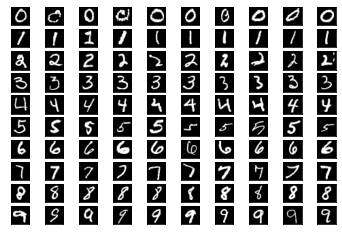

In [198]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

model = KMeans(init="k-means++", n_clusters=10, random_state=0)
model.fit(new_X_train)
y_pred = new_y_train

def viz_img(y_pred):
    n = 10
    fig = plt.figure(1)
    box_index = 1
    for cluster in range(10):
        result = np.where(y_pred == cluster)
        for i in np.random.choice(result[0].tolist(), n, replace=False):
            ax = fig.add_subplot(n, n, box_index)
            plt.imshow(new_X_train[i].reshape(28, 28))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            box_index += 1
    plt.show()
    
viz_img(y_pred)